In [1]:
import numpy as np
import os
import netCDF4
from scipy import stats
from scipy import io
from sstanalysis import gfd
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
from sstanalysis import popmodel
reload(popmodel)

<module 'sstanalysis.popmodel' from 'sstanalysis/popmodel.pyc'>

In [3]:
def fit_loglog(x, y):
    # fig log vs log
    p = np.polyfit(np.log2(x), np.log2(y), 1)
    y_fit = 2**(np.log2(x)*p[0] + p[1])
    #A = np.vstack([np.log2(x), np.ones(len(x))]).T
    #a, b = np.linalg.lstsq(A, np.log2(y))[0]
    #y_fit = 2**(np.log2(x)*a + b)
    
    return y_fit, p[0]

1649 1899 1494 1667
11.767448308 49.2027441065 140.05 232.085004027
(500, 900) (500, 900) (500, 900)


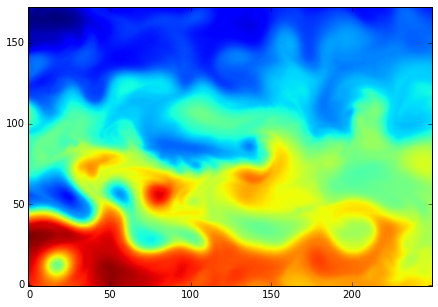

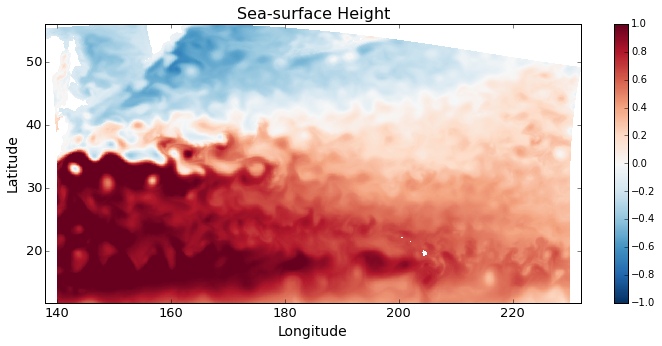

In [8]:
roll = -1000
west, est, sud, nord = 154.9, 180., 30., 45.4
lonrange=np.array([west,est]) 
latrange=np.array([sud,nord])

base_dir = '../../../data/scratch/rpa/cesm/hybrid_v5_rel04_BC5_ne120_t12_pop62/'
fname = base_dir + 'hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0046-02-01.nc'
f = netCDF4.Dataset(fname)

SSH = np.roll(f.variables['SSH_2'][0], roll)  # SST(time, lat, lon)
#U = np.roll(f.variables['U1_1'][0], roll)
tlon = np.roll(f.variables['TLONG'][:], roll)
tlat = np.roll(f.variables['TLAT'][:], roll)

# step 1: figure out the box indices
lonmask = (tlon >= lonrange[0]) & (tlon < lonrange[1])
latmask = (tlat >= latrange[0]) & (tlat < latrange[1])
boxidx = lonmask & latmask # this won't necessarily be square
irange = np.where(boxidx.sum(axis=0))[0]
imin, imax = irange.min(), irange.max()
jrange = np.where(boxidx.sum(axis=1))[0]
jmin, jmax = jrange.min(), jrange.max()
print imin, imax, jmin, jmax

SSH_domain = SSH[..., jmin:jmax, imin:imax]
#U_domain = U[..., jmin:jmax, imin:imax]
jLs, jLe = (1300,1800)
iLs, iLe = (1500,2400)
print tlat[jLs,iLs], tlat[jLe,iLe], tlon[jLs,iLs], tlon[jLe,iLe]

plt.figure(figsize=(18,5))
#plt.subplot(121)
plt.imshow(SSH_domain, origin='bottom')
#plt.subplot(122)
plt.figure(figsize=(12,5))
plt.pcolormesh(tlon[jLs:jLe, iLs:iLe], tlat[jLs:jLe, iLs:iLe], SSH[..., jLs:jLe, iLs:iLe]*1e-2, cmap ='RdBu_r')
plt.title('Sea-surface Height',fontsize=16)
plt.xlabel('Longitude',fontsize=14)
plt.ylabel('Latitude',fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.clim([-1,1])
plt.axis('tight')
plt.colorbar()

#plt.figure(figsize=(10,10))
#plt.imshow(U_domain, origin='bottom')
print tlon[jLs:jLe, iLs:iLe].shape, tlat[jLs:jLe, iLs:iLe].shape, SSH[..., jLs:jLe, iLs:iLe].shape

In [4]:
dlat, dlon = (10., 10.)
#dwest, dsouth = (11., 11.)
lat_start, lat_end = (12., 54.)
lon_start, lon_end = (140., 232.1)
west, south = (lon_start, lat_start)
east, north = (west+dlon, south+dlat)
Degx, Degy = (int((lon_end-lon_start)/dlon), int((lat_end-lat_start)/dlat))
Lon = np.zeros((Degy+1,Degx+1))
Lat = np.zeros((Degy+1,Degx+1))
#Lon_max = np.zeros((Degy,Degx))
#Lat_max = np.zeros((Degy,Degx))
#Lon_upright_corn = 0.
#Lat_upright_corn = 0.
psd_slopes_Feb = np.zeros((Degy,Degx))
psd_slopes_Aug = np.zeros((Degy,Degx))
psd_level_Feb = np.zeros((Degy,Degx))
psd_level_Aug = np.zeros((Degy,Degx))
L_1 = np.zeros((Degy,Degx)) 
base_dir = '../../../data/scratch/rpa/cesm/hybrid_v5_rel04_BC5_ne120_t12_pop62/'

print Degx, Degy
print Lon.shape

9 4
(5, 10)


# PSD #

sstanalysis/popmodel.py:323: UserWarning: The sector has land (land_fraction=0.000777001) but we are interpolating it out.
  warnings.warn(errstr)
sstanalysis/popmodel.py:418: RuntimeWarning: invalid value encountered in divide
  np.bincount(Kidx, weights=(breve2_ave).ravel()) / area )[1:] *Ki*2.*np.pi**2
sstanalysis/popmodel.py:323: UserWarning: The sector has land (land_fraction=9.71251e-05) but we are interpolating it out.
  warnings.warn(errstr)
sstanalysis/popmodel.py:318: UserWarning: The sector has too much land. land_fraction = 0.0143745143745
  warnings.warn(errstr)
-c:3: RuntimeWarning: divide by zero encountered in log2
sstanalysis/popmodel.py:323: UserWarning: The sector has land (land_fraction=0.000811688) but we are interpolating it out.
  warnings.warn(errstr)
sstanalysis/popmodel.py:318: UserWarning: The sector has too much land. land_fraction = 0.0839354205691
  warnings.warn(errstr)
sstanalysis/popmodel.py:318: UserWarning: The sector has too much land. land_fraction 

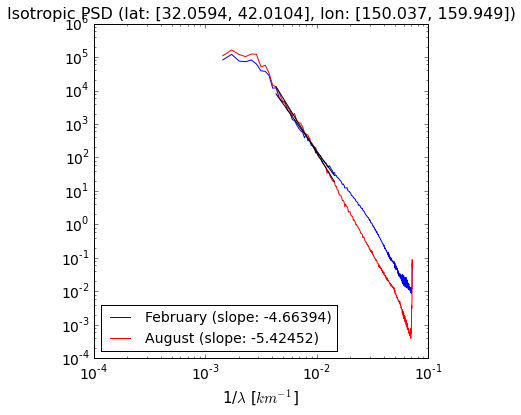

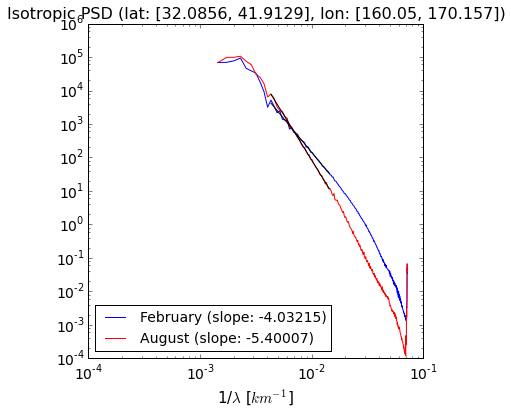

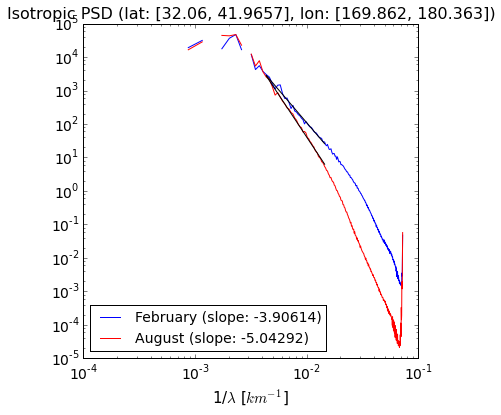

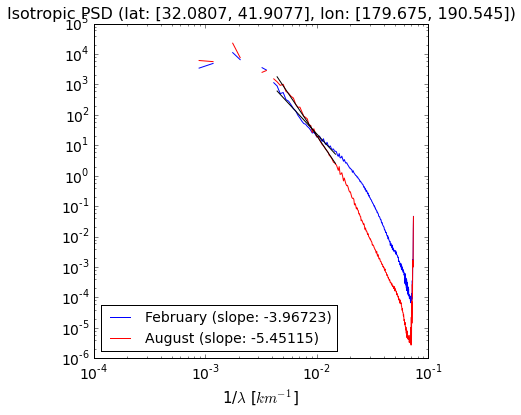

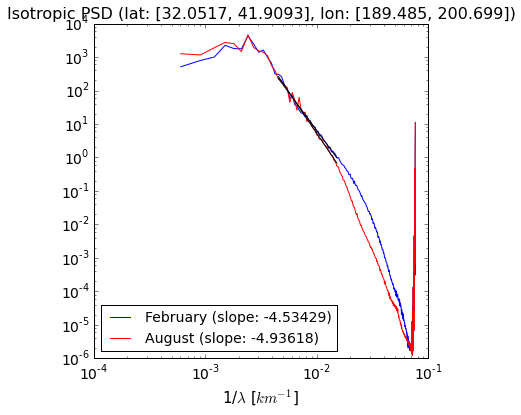

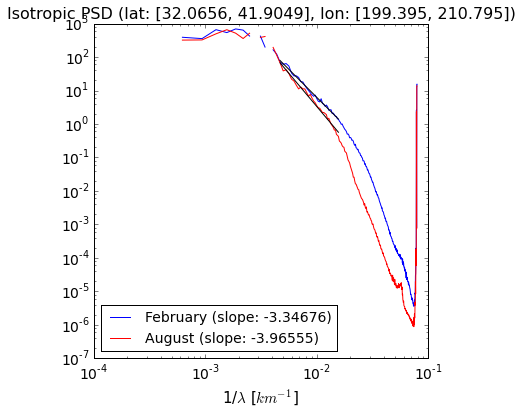

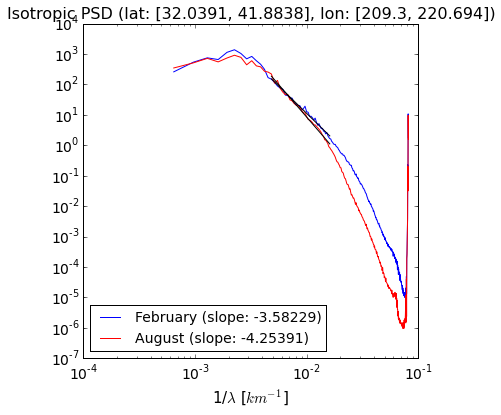

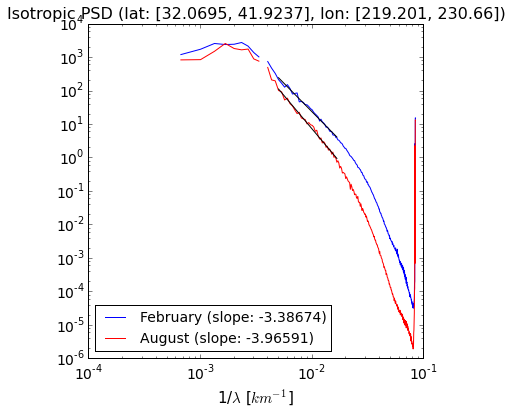

In [8]:
j,i = (0,0)
while north<=lat_end+dlat:
    west = lon_start
    east = west+dlon
    i = 0
    while east<=lon_end+dlon:
        if north <= lat_end:
            if east <= lon_end:
                # February
                NtFeb = 0.
                # load data files
                nday = 1
                for yearnum in np.arange(1,6):
                    daynum = 0
                    #for month in np.arange(1,13):
                    fname = os.path.join(base_dir,
                                 'hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday%1d.%04d-02-01.nc' 
                                 % (nday, yearnum+45))
                    #print fname
                    p = popmodel.POPFile(fname)
                    #T = p.nc.variables['SST'][:]
                    Nt_Feb, Nx, Ny, k, l, spac2_ave_Feb, tilde2_ave_Feb, breve2_ave_Feb, Ki, isospec_Feb, area, lon, lat, land_frac, MAX_LAND = p.power_spectrum_2d(
                                                                                                        varname='SSH_2', lonrange=(west,east), latrange=(south,north))
                    if yearnum == 1:
                        N = len(Ki)
                        isospec_sum_Feb = np.zeros(N)
                    isospec_sum_Feb += isospec_Feb
                    #NtFeb += Nt_Feb

                isospec_ave_Feb = isospec_sum_Feb/yearnum
        
                # August
                NtAug = 0.
                # load data files
                nday = 1
                for yearnum in np.arange(1,6):
                    daynum = 0
                    #for month in np.arange(1,13):
                    fname = os.path.join(base_dir, 
                                 'hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday%1d.%04d-08-01.nc' 
                                 % (nday, yearnum+45))
                    #print fname
                    p = popmodel.POPFile(fname)
                    #T = p.nc.variables['SST'][:]
                    Nt_Aug, Nx, Ny, k, l, spac2_ave_Aug, tilde2_ave_Aug, breve2_ave_Aug, Ki, isospec_Aug, area, lon, lat, land_frac, MAX_LAND = p.power_spectrum_2d(
                                                                                                            varname='SSH_2', lonrange=(west,east), latrange=(south,north))
                    if yearnum == 1:
                        N = len(Ki)
                        isospec_sum_Aug = np.zeros(N)
                    isospec_sum_Aug += isospec_Aug
                    #NtAug += Nt_Aug

                isospec_ave_Aug = isospec_sum_Aug/yearnum
        
                Ns = 15
                Ne = N/5
                ps_fit_Feb, ps_slope_Feb = fit_loglog(Ki[Ns:Ne], isospec_ave_Feb[Ns:Ne])
                ps_fit_Aug, ps_slope_Aug= fit_loglog(Ki[Ns:Ne], isospec_ave_Aug[Ns:Ne])
        
        roll = -1000
        fname = base_dir + 'hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0046-02-01.nc'
        f = netCDF4.Dataset(fname)
        SSH = np.roll(f.variables['SSH_2'][0], roll)  # SST(time, lat, lon)
        #U = np.roll(f.variables['U1_1'][0], roll)
        tlon = np.roll(f.variables['TLONG'][:], roll)
        tlat = np.roll(f.variables['TLAT'][:], roll)

        lonrange=np.array([west,east])
        latrange=np.array([south,north])
        lonmask = (tlon >= lonrange[0]) & (tlon < lonrange[1])
        latmask = (tlat >= latrange[0]) & (tlat < latrange[1])
        boxidx = lonmask & latmask # this won't necessarily be square
        irange = np.where(boxidx.sum(axis=0))[0]
        imin, imax = irange.min(), irange.max()
        jrange = np.where(boxidx.sum(axis=1))[0]
        jmin, jmax = jrange.min(), jrange.max()
        #print imin, imax, jmin, jmax

        SSH_domain = SSH[..., jmin:jmax, imin:imax]
        #U_domain = U[..., jmin:jmax, imin:imax]


        if north <= lat_end:
            if east <= lon_end:
                if land_frac<MAX_LAND:
                    Lon[j,i] = tlon[jmin,imin]
                    Lat[j,i] = tlat[jmin,imin]
                    #Lon_max[j,i] = tlon[jmin,imax]
                    #Lat_max[j,i] = tlat[jmax,imin]
                    #Lon_upright_corn = tlon[jmax,imax]
                    #Lat_upright_corn = tlat[jmax,imax]
                    psd_slopes_Feb[j,i] = ps_slope_Feb
                    psd_slopes_Aug[j,i] = ps_slope_Aug
                    psd_level_Feb[j,i] = ps_fit_Feb[-1]
                    psd_level_Aug[j,i] = ps_fit_Aug[-1]
                    L_1[j,i] = Ki[-1]
                    if north > lat_end-2*dlat and north <= lat_end-dlat:
                        plt.figure(figsize=(6,6))
                        #plt.subplot(121)
                        #plt.pcolormesh(tlon[jmin:jmax, imin:imax], tlat[jmin:jmax, imin:imax], SST_domain)
                        #plt.title('SST (Land coverage: %g)' % land_frac, fontsize=16)
                        #plt.xticks(fontsize=14)
                        #plt.yticks(fontsize=14)
                        #plt.subplot(122)
                        plt.loglog(Ki*.5/np.pi*1e3, isospec_ave_Feb, 'b', label=r'February (slope: %g)' % ps_slope_Feb)
                        plt.loglog(Ki*.5/np.pi*1e3, isospec_ave_Aug, 'r', label=r'August (slope: %g)' % ps_slope_Aug)
                        plt.loglog(Ki[Ns:Ne]*.5/np.pi*1e3, ps_fit_Feb, 'k')
                        plt.loglog(Ki[Ns:Ne]*.5/np.pi*1e3, ps_fit_Aug, 'k')
                        plt.xlabel('1/$\lambda$ [$km^{-1}$]', fontsize=15)
                        plt.title('Isotropic PSD (lat: [%g, %g], lon: [%g, %g])' % (tlat[jmin,imin], tlat[jmax,imax], tlon[jmin,imin], tlon[jmax,imax]), fontsize=16)
                        plt.legend(loc='lower left', fontsize=14)
                        plt.xticks(fontsize=14)
                        plt.yticks(fontsize=14)
                else:
                    Lon[j,i] = tlon[jmin,imin]
                    Lat[j,i] = tlat[jmin,imin]
                    #Lon_max[j,i] = tlon[jmin,imax]
                    #Lat_max[j,i] = tlat[jmax,imin]
                    #Lon_upright_corn = tlon[jmax,imax]
                    #Lat_upright_corn = tlat[jmax,imax]
                    psd_slopes_Feb[j,i] = np.nan
                    psd_slopes_Aug[j,i] = np.nan
                    psd_level_Feb[j,i] = np.nan
                    psd_level_Aug[j,i] = np.nan
                    L_1[j,i] = np.nan
            
                    #plt.figure(figsize=(15,4))
                    #plt.subplot(121)
                    #plt.pcolormesh(tlon[jmin:jmax, imin:imax], tlat[jmin:jmax, imin:imax], SST_domain)
                    #plt.title('SST (Land coverage: %g)' % land_frac, fontsize=16)
                    #plt.xticks(fontsize=14)
                    #plt.yticks(fontsize=14)
            else:
                Lon[j,i] = tlon[jmin,imin]
                Lat[j,i] = tlat[jmin,imin]
        else:
            Lon[j,i] = tlon[jmin,imin]
            Lat[j,i] = tlat[jmin,imin]
        
        west = east
        east = west+dlon
        i += 1
    
    south = north
    north = south+dlat
    j += 1
    
    
        

In [9]:
fname = 'psd_slope_SSH_Pacific.mat' 
#fw = open(filename, 'w')
io.savemat(fname, {'Feb':psd_slopes_Feb, 'Aug':psd_slopes_Aug, 'Lat':Lat, 'Lon':Lon})

fname = 'psd_level_SSH_Pacific.mat' 
#fw = open(filename, 'w')
io.savemat(fname, {'Feb':psd_level_Feb, 'Aug':psd_level_Aug, 'LenScale':(L_1*.5/np.pi)**-1*1e-3})

<matplotlib.colorbar.Colorbar instance at 0x7f9b400a14d0>

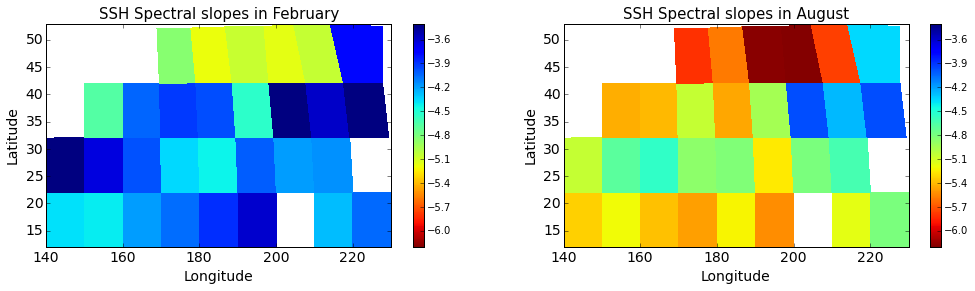

In [11]:
plt.figure(figsize=(17,4))
plt.subplot(121)
plt.pcolormesh(Lon, Lat, np.ma.masked_invalid(psd_slopes_Feb),cmap='jet_r')
plt.title('SSH Spectral slopes in February', fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.clim([-6.2,-3.4])
plt.axis([Lon.min(), Lon.max(), Lat.min(), Lat.max()])
plt.colorbar()
plt.subplot(122)
plt.pcolormesh(Lon, Lat, np.ma.masked_invalid(psd_slopes_Aug),cmap='jet_r')
plt.title('SSH Spectral slopes in August', fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.clim([-6.2,-3.4])
plt.axis([Lon.min(), Lon.max(), Lat.min(), Lat.max()])
plt.colorbar()

-5.67101529222 -3.65615534617


<matplotlib.colorbar.Colorbar instance at 0x7f62030eb050>

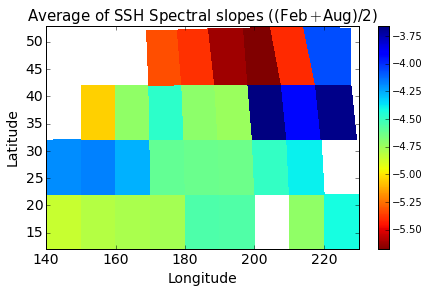

In [27]:
Ave = .5*(psd_slopes_Feb+psd_slopes_Aug)
print np.nanmin(Ave),np.nanmax(Ave)

plt.figure(figsize=(7,4))
plt.pcolormesh(Lon, Lat, np.ma.masked_invalid(Ave),cmap='jet_r')
plt.title('Average of SSH Spectral slopes ((Feb$+$Aug)/2)', fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.clim([np.nanmin(Ave),np.nanmax(Ave)])
plt.axis([Lon.min(), Lon.max(), Lat.min(), Lat.max()])
plt.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x7f1cfcd766c8>

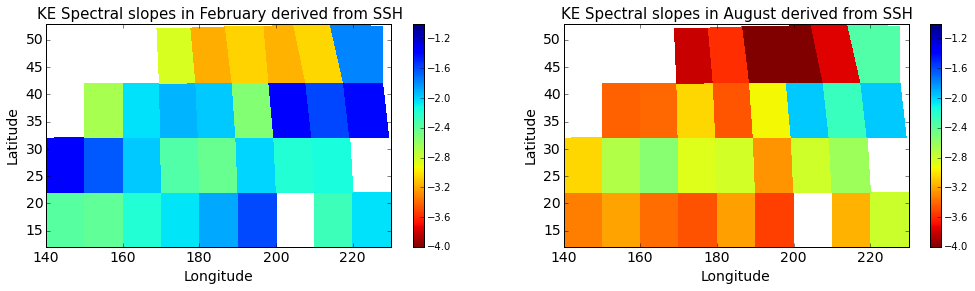

In [14]:
plt.figure(figsize=(17,4))
plt.subplot(121)
plt.pcolormesh(Lon, Lat, np.ma.masked_invalid(psd_slopes_Feb+2),cmap='jet_r')
plt.title('KE Spectral slopes in February derived from SSH', fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.clim([-4,-1])
plt.axis([Lon.min(), Lon.max(), Lat.min(), Lat.max()])
plt.colorbar()
plt.subplot(122)
plt.pcolormesh(Lon, Lat, np.ma.masked_invalid(psd_slopes_Aug+2),cmap='jet_r')
plt.title('KE Spectral slopes in August derived from SSH', fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.clim([-4,-1])
plt.axis([Lon.min(), Lon.max(), Lat.min(), Lat.max()])
plt.colorbar()

In [15]:
fname = 'psd_slope_Vel_Pacific.mat'
f_psd = io.loadmat(fname)

psd_slopes_Feb_KE = f_psd['Feb']
psd_slopes_Aug_KE = f_psd['Aug']

<matplotlib.colorbar.Colorbar instance at 0x7f1cfadefcb0>

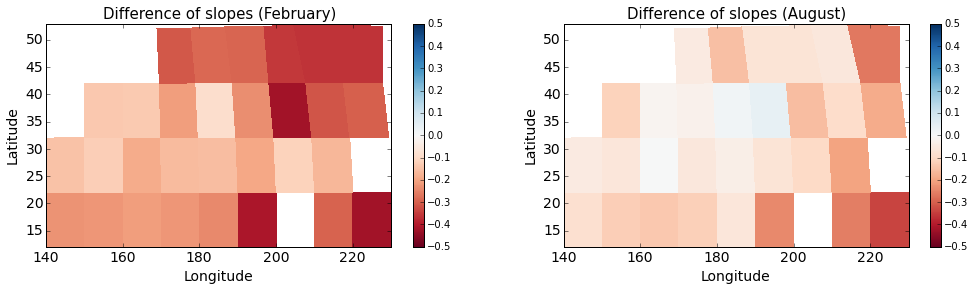

In [21]:
plt.figure(figsize=(17,4))
plt.subplot(121)
plt.pcolormesh(Lon, Lat, np.ma.masked_invalid(psd_slopes_Feb_KE-psd_slopes_Feb-2),cmap='RdBu')
plt.title('Difference of slopes (February)', fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.clim([-.5,.5])
plt.axis([Lon.min(), Lon.max(), Lat.min(), Lat.max()])
plt.colorbar()
plt.subplot(122)
plt.pcolormesh(Lon, Lat, np.ma.masked_invalid(psd_slopes_Aug_KE-psd_slopes_Aug-2),cmap='RdBu')
plt.title('Difference of slopes (August)', fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.clim([-.5,.5])
plt.axis([Lon.min(), Lon.max(), Lat.min(), Lat.max()])
plt.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x7f1cfa2bbef0>

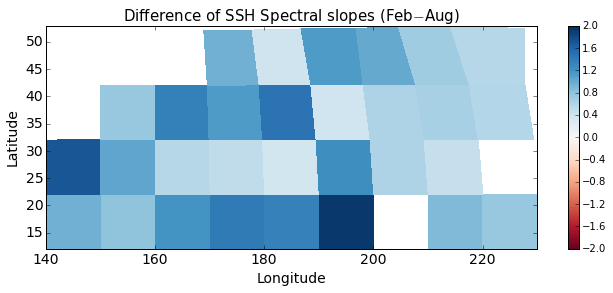

In [27]:
plt.figure(figsize=(11,4))
plt.pcolormesh(Lon, Lat, np.ma.masked_invalid(psd_slopes_Feb-psd_slopes_Aug),cmap='RdBu')
plt.title('Difference of SSH Spectral slopes (Feb$-$Aug)', fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.clim([-2.,2.])
plt.axis([Lon.min(), Lon.max(), Lat.min(), Lat.max()])
plt.colorbar()

# Structure Function #

sstanalysis/popmodel.py:490: UserWarning: The sector has land (land_fraction=0.0143745).
  warn(errstr)
-c:3: RuntimeWarning: divide by zero encountered in log2
sstanalysis/popmodel.py:490: UserWarning: The sector has land (land_fraction=0.0839354).
  warn(errstr)
sstanalysis/popmodel.py:490: UserWarning: The sector has land (land_fraction=0.198223).
  warn(errstr)
sstanalysis/popmodel.py:490: UserWarning: The sector has land (land_fraction=0.0175174).
  warn(errstr)


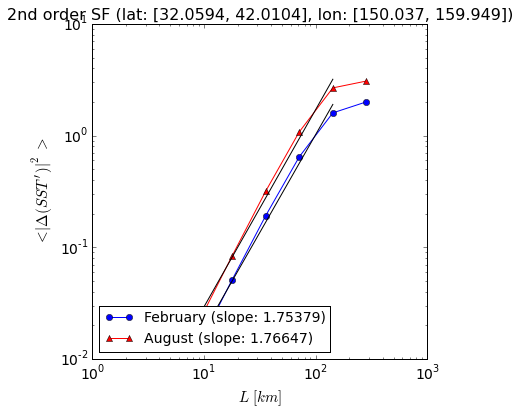

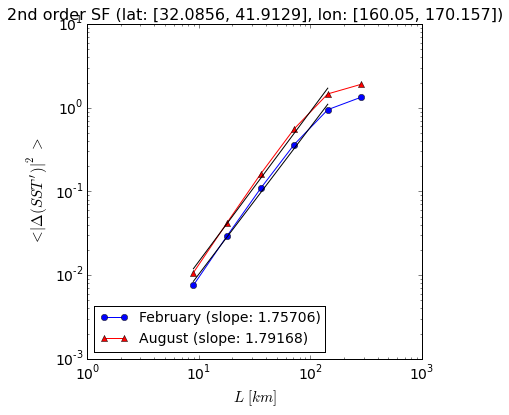

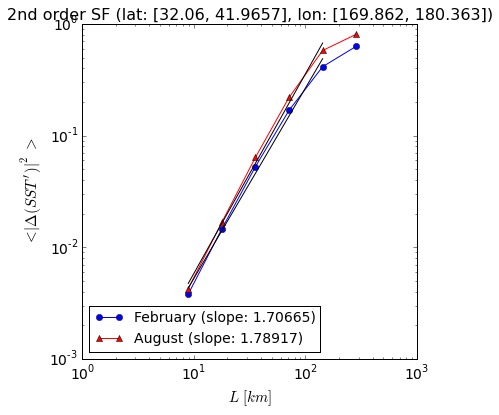

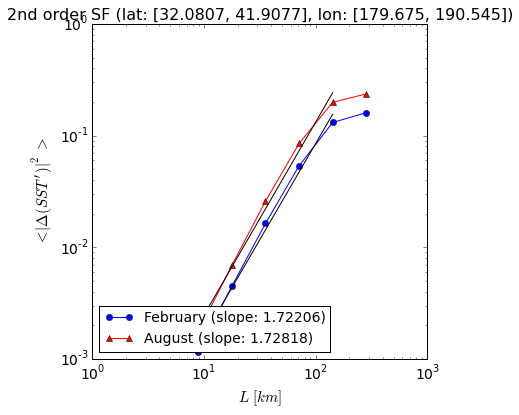

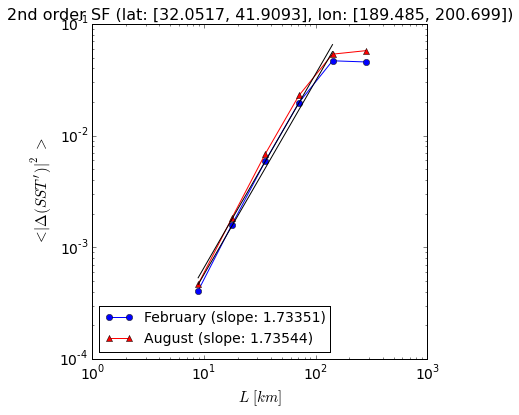

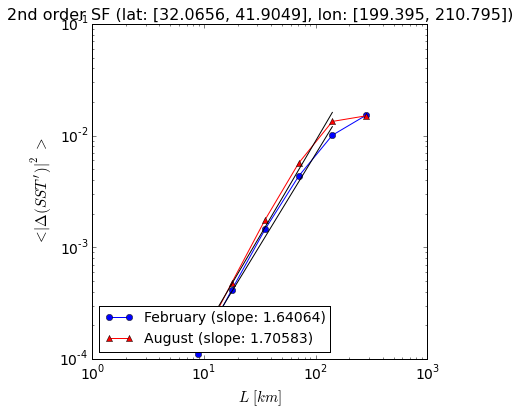

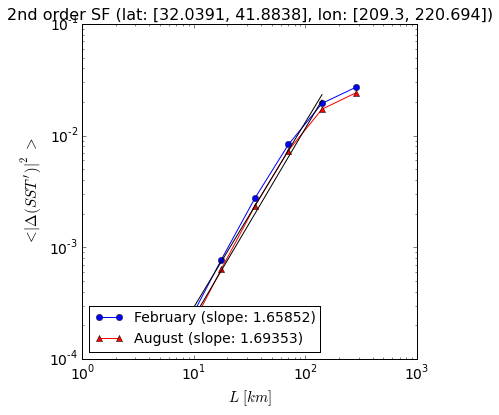

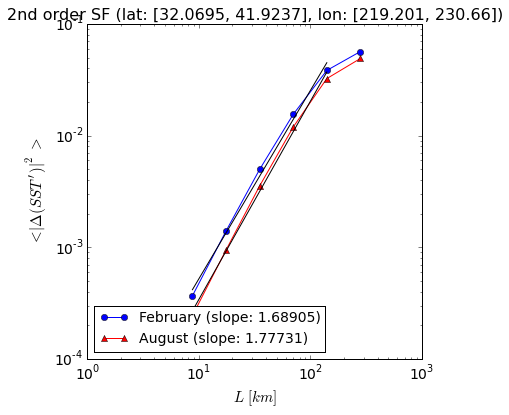

In [5]:
sf_slopes_Feb = np.zeros((Degy,Degx))
sf_slopes_Aug = np.zeros((Degy,Degx))
sf_level_Feb = np.zeros((Degy,Degx))
sf_level_Aug = np.zeros((Degy,Degx))
L_sf = np.zeros((Degy,Degx)) 

j,i = (0,0)
while north<=lat_end+dlat:
    west = lon_start
    east = west+dlon
    i = 0
    while east<=lon_end+dlon:
        if north <= lat_end:
            if east <= lon_end:
                # February
                NtFeb = 0.
                # load data files
                nday = 1
                for yearnum in np.arange(1,6):
                    daynum = 0
                    #for month in np.arange(1,13):
                    fname = os.path.join(base_dir,
                                 'hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday%1d.%04d-02-01.nc' 
                                 % (nday, yearnum+45))
                    #print fname
                    p = popmodel.POPFile(fname)
                    #T = p.nc.variables['SST'][:]
                    Nt_Feb, dx, dy, L_Feb, SFi_Feb, SFj_Feb, lon, lat, land_frac, MAX_LAND = p.structure_function(
                                                                                                        varname='SSH_2', lonrange=(west,east), latrange=(south,north))
                    if yearnum == 1:
                        N = len(L_Feb)
                        StrucFunc_sum_Febi = np.zeros(N)
                        StrucFunc_sum_Febj = np.zeros(N)
                    StrucFunc_sum_Febi += SFi_Feb
                    StrucFunc_sum_Febj += SFj_Feb
                    NtFeb += Nt_Feb

                StrucFunc_ave_Febi = StrucFunc_sum_Febi/NtFeb
                StrucFunc_ave_Febj = StrucFunc_sum_Febj/NtFeb
                StrucFunc_ave_Feb = .5*(StrucFunc_ave_Febi+StrucFunc_sum_Febj)
        
                # August
                NtAug = 0.
                # load data files
                nday = 1
                for yearnum in np.arange(1,6):
                    daynum = 0
                    #for month in np.arange(1,13):
                    fname = os.path.join(base_dir, 
                                 'hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday%1d.%04d-08-01.nc' 
                                 % (nday, yearnum+45))
                    #print fname
                    p = popmodel.POPFile(fname)
                    #T = p.nc.variables['SST'][:]
                    Nt_Aug, dx, dy, L_Aug, SFi_Aug, SFj_Aug, lon, lat, land_frac, MAX_LAND = p.structure_function(
                                                                                                        varname='SSH_2', lonrange=(west,east), latrange=(south,north))
                    if yearnum == 1:
                        N = len(L_Aug)
                        StrucFunc_sum_Augi = np.zeros(N)
                        StrucFunc_sum_Augj = np.zeros(N)
                    StrucFunc_sum_Augi += SFi_Aug
                    StrucFunc_sum_Augj += SFj_Aug
                    NtAug += Nt_Aug

                StrucFunc_ave_Augi = StrucFunc_sum_Augi/NtAug
                StrucFunc_ave_Augj = StrucFunc_sum_Augj/NtAug
                StrucFunc_ave_Aug = .5*(StrucFunc_ave_Augi+StrucFunc_sum_Augj)
        
                sf_fit_Feb, sf_slope_Feb = fit_loglog(L_Feb[:-1], StrucFunc_ave_Feb[:-1])
                sf_fit_Aug, sf_slope_Aug = fit_loglog(L_Aug[:-1], StrucFunc_ave_Aug[:-1])
        
        roll = -1000
        fname = base_dir + 'hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0046-02-01.nc'
        f = netCDF4.Dataset(fname)
        SSH = np.roll(f.variables['SSH_2'][0], roll)  # SST(time, lat, lon)
        #U = np.roll(f.variables['U1_1'][0], roll)
        tlon = np.roll(f.variables['TLONG'][:], roll)
        tlat = np.roll(f.variables['TLAT'][:], roll)

        lonrange=np.array([west,east])
        latrange=np.array([south,north])
        lonmask = (tlon >= lonrange[0]) & (tlon < lonrange[1])
        latmask = (tlat >= latrange[0]) & (tlat < latrange[1])
        boxidx = lonmask & latmask # this won't necessarily be square
        irange = np.where(boxidx.sum(axis=0))[0]
        imin, imax = irange.min(), irange.max()
        jrange = np.where(boxidx.sum(axis=1))[0]
        jmin, jmax = jrange.min(), jrange.max()
        #print imin, imax, jmin, jmax

        #SST_domain = SST[..., jmin:jmax, imin:imax]
        #U_domain = U[..., jmin:jmax, imin:imax]

        #N = len(StrucFunc_ave_Feb)
        x = 2**np.arange(N)*dx*1e-3
        y = 2**np.arange(N)*dy*1e-3

        if north <= lat_end:
            if east <= lon_end:
                if land_frac<MAX_LAND:
                    Lon[j,i] = tlon[jmin,imin]
                    Lat[j,i] = tlat[jmin,imin]
                    sf_slopes_Feb[j,i] = sf_slope_Feb
                    sf_slopes_Aug[j,i] = sf_slope_Aug
                    sf_level_Feb[j,i] = sf_fit_Feb[0]
                    sf_level_Aug[j,i] = sf_fit_Aug[0]
                    L_sf[j,i] = L_Feb[0]
                    if north > lat_end-2*dlat and north <= lat_end-dlat:
                    #if north <= lat_end:
                        plt.figure(figsize=(6,6))
                        #plt.subplot(121)
                        #plt.pcolormesh(tlon[jmin:jmax, imin:imax], tlat[jmin:jmax, imin:imax], SST_domain)
                        #plt.title('SST (Land coverage: %g)' % land_frac, fontsize=16)
                        #plt.xticks(fontsize=14)
                        #plt.yticks(fontsize=14)
                        #plt.subplot(122)
                        plt.loglog(x, StrucFunc_ave_Feb, 'bo-', label=r'February (slope: %g)' % sf_slope_Feb)
                        plt.loglog(x, StrucFunc_ave_Aug, 'r^-', label=r'August (slope: %g)' % sf_slope_Aug) 
                        plt.loglog(x[:-1], sf_fit_Feb, 'k')
                        plt.loglog(x[:-1], sf_fit_Aug, 'k')
                        plt.xlabel('$L \  [km]$', fontsize=15)
                        plt.ylabel('$< {| \Delta ({SST}^{\ \prime}) |}^2 >$', fontsize=15)
                        plt.title('2nd order SF (lat: [%g, %g], lon: [%g, %g])' % (tlat[jmin,imin], tlat[jmax,imax], tlon[jmin,imin], tlon[jmax,imax]), fontsize=16)
                        plt.legend(loc='lower left', fontsize=14)
                        plt.xticks(fontsize=14)
                        plt.yticks(fontsize=14)
                else:
                    Lon[j,i] = tlon[jmin,imin]
                    Lat[j,i] = tlat[jmin,imin]
                    sf_slopes_Feb[j,i] = np.nan
                    sf_slopes_Aug[j,i] = np.nan
                    sf_level_Feb[j,i] = np.nan
                    sf_level_Aug[j,i] = np.nan
                    L_sf[j,i] = np.nan
            
                    #plt.figure(figsize=(15,6))
                    #plt.subplot(121)
                    #plt.pcolormesh(tlon[jmin:jmax, imin:imax], tlat[jmin:jmax, imin:imax], SST_domain)
                    #plt.title('SST (Land coverage: %g)' % land_frac, fontsize=16)
                    #plt.xticks(fontsize=14)
                    #plt.yticks(fontsize=14)
            else:
                Lon[j,i] = tlon[jmin,imin]
                Lat[j,i] = tlat[jmin,imin]
        else:
            Lon[j,i] = tlon[jmin,imin]
            Lat[j,i] = tlat[jmin,imin]
        

        west = east
        east = west+dlon
        i += 1
    south = north
    north = south+dlat
    j += 1

In [6]:
fname = 'sf_slope_SSH_Pacific.mat' 
#fw = open(filename, 'w')
io.savemat(fname, {'Feb':sf_slopes_Feb, 'Aug':sf_slopes_Aug, 'Lat':Lat, 'Lon':Lon})

fname = 'sf_level_SSH_Pacific.mat' 
#fw = open(filename, 'w')
io.savemat(fname, {'Feb':sf_level_Feb, 'Aug':sf_level_Aug, 'LenScale':L_sf})

In [12]:
fname = 'sf_slope_SSH_Pacific.mat'
f_sf = io.loadmat(fname)

print f_sf.keys()

fname = 'psd_slope_SSH_Pacific.mat'
f_psd = io.loadmat(fname)

print f_psd.keys()

psd_slopes_Feb = f_psd['Feb']
psd_slopes_Aug = f_psd['Aug']

sf_slopes_Feb = f_sf['Feb']
sf_slopes_Aug = f_sf['Aug']
Lon = f_sf['Lon']
Lat = f_sf['Lat']

['Feb', 'Aug', 'Lon', '__header__', '__globals__', 'Lat', '__version__']
['Feb', 'Aug', 'Lon', '__header__', '__globals__', 'Lat', '__version__']


<matplotlib.colorbar.Colorbar instance at 0x7f1cfca284d0>

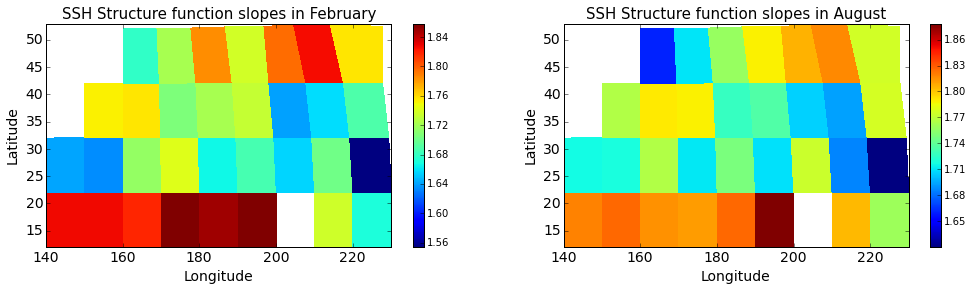

In [6]:
plt.figure(figsize=(17,4))
plt.subplot(121)
plt.pcolormesh(Lon, Lat, np.ma.masked_invalid(sf_slopes_Feb), cmap='jet')
plt.title('SSH Structure function slopes in February', fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
#plt.clim([1,1.4])
plt.axis([Lon.min(), Lon.max(), Lat.min(), Lat.max()])
plt.colorbar()
plt.subplot(122)
plt.pcolormesh(Lon, Lat, np.ma.masked_invalid(sf_slopes_Aug), cmap='jet')
plt.title('SSH Structure function slopes in August', fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
#plt.clim([1,1.4])
plt.axis([Lon.min(), Lon.max(), Lat.min(), Lat.max()])
plt.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x7f1cfcdf4638>

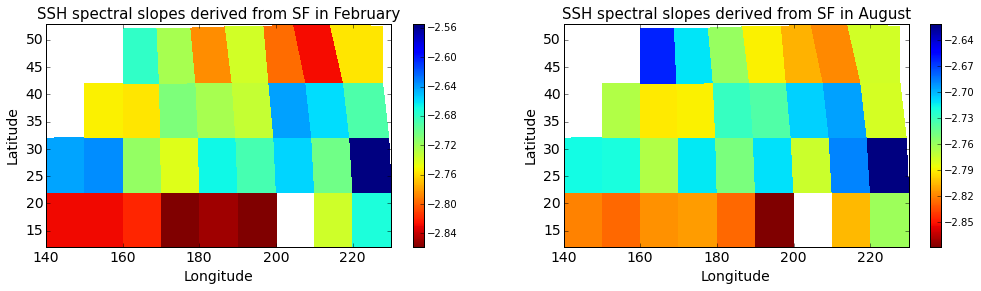

In [7]:
plt.figure(figsize=(17,4))
plt.subplot(121)
plt.pcolormesh(Lon, Lat, np.ma.masked_invalid(-sf_slopes_Feb-1), cmap='jet_r')
plt.title('SSH spectral slopes derived from SF in February', fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
#plt.clim([-6.2,-3.4])
plt.axis([Lon.min(), Lon.max(), Lat.min(), Lat.max()])
plt.colorbar()
plt.subplot(122)
plt.pcolormesh(Lon, Lat, np.ma.masked_invalid(-sf_slopes_Aug-1), cmap='jet_r')
plt.title('SSH spectral slopes derived from SF in August', fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
#plt.clim([-6.2,-3.4])
plt.axis([Lon.min(), Lon.max(), Lat.min(), Lat.max()])
plt.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x7f1cf9ae8cb0>

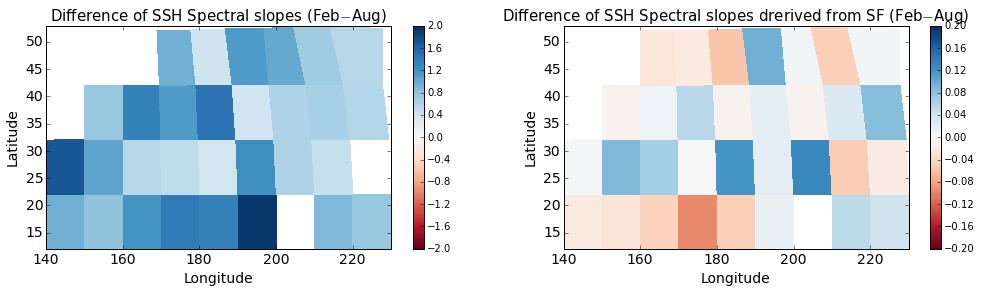

In [30]:
plt.figure(figsize=(17,4))
plt.subplot(121)
plt.pcolormesh(Lon, Lat, np.ma.masked_invalid(psd_slopes_Feb-psd_slopes_Aug),cmap='RdBu')
plt.title('Difference of SSH Spectral slopes (Feb$-$Aug)', fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.clim([-2.,2.])
plt.axis([Lon.min(), Lon.max(), Lat.min(), Lat.max()])
plt.colorbar()
plt.subplot(122)
plt.pcolormesh(Lon, Lat, np.ma.masked_invalid((-sf_slopes_Feb-1)-(-sf_slopes_Aug-1)),cmap='RdBu')
plt.title('Difference of SSH Spectral slopes drerived from SF (Feb$-$Aug)', fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.clim([-.2,.2])
plt.axis([Lon.min(), Lon.max(), Lat.min(), Lat.max()])
plt.colorbar()